In [5]:
pip install numba


   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 57.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ----------- ---------------------------- 11.0/38.1 MB 53.5 MB/s eta 0:00:01
   ------------------------ --------------- 23.3/38.1 MB 55.7 MB/s eta 0:00:01
   ------------------------------------ --- 35.1/38.1 MB 55.8 MB/s eta 0:00:01
   ---------------------------------------- 38.1/38.1 MB 53.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from numba import njit
from __future__ import division
import numpy as np
import random as rnd

be = 1.1 # windsock parameter
ks = 0.027 # spring constant for the confining potential
gam = 18. # friction coefficient of the propulsive force
dt = 0.001 # timestep for the integration of the equations of motion
eps = 0.025 # eta/gamma_p with eta the amplitude of the non-linear correction to the windsock amplification and gamma_p the friction coefficient of the propulsive force
sigma = 2. # amplitude of the noise
nsteps = 1500000 # number of steps over which spectra are computed
nsteps_relax = 150000 # number of steps which are thrown away at the beginning of the simulation (to reach steady-state)
nrun = 100 # number of different runs, spectra are computed by averaging over all the runs
window_size =  10 # size of the moving average to smooth the spectrum before defining the band-pass filter and computing the spin field
thres = 0.75 # threshold value on the spectrum to determine the frequency range over which the band-pass filter is non-zero to define the spin

@njit
def dynamics(Y, k, beta, gamma_p, epsilon):
    ux, uy, px, py = Y
    prod_p = px * py
    norm_p2 = px * px + py * py

    dux = -k * ux + px
    duy = -k * uy + py

    common = - gamma_p * (1. - beta + beta * epsilon * norm_p2)
    dpx = (common * px
           - k * beta * gamma_p * (1. - epsilon * norm_p2) * ux
           - k * prod_p * uy
           + k * py * py * ux)

    dpy = (common * py
           - k * beta * gamma_p * (1. - epsilon * norm_p2) * uy
           - k * prod_p * ux
           + k * px * px * uy)

    return np.array([dux, duy, dpx, dpy])
    
def ICs(k, beta, gamma_p, epsilon):
    if beta > 1. + k / gamma_p:
        angle = rnd.uniform(- np.pi, np.pi)
        unorm = np.sqrt(gamma_p * 0.5 / k / k / ( 1. + beta * epsilon * gamma_p ) * ( beta - 1. - k / gamma_p - beta * epsilon * gamma_p - k / gamma_p * ( 1. + beta * epsilon * gamma_p ) + np.sqrt(( beta - 1. - k / gamma_p - beta * epsilon * gamma_p + k / gamma_p * ( 1. + beta * epsilon * gamma_p ) ) ** 2 + 4. * k * beta * epsilon * ( 1. + beta * epsilon * gamma_p )) ))
        omega = np.sqrt(k * gamma_p / ( 1. + k * unorm * unorm ))
        if rnd.random() > 0.5:
            omega = - omega
        ux = unorm * np.cos(angle)
        uy = unorm * np.sin(angle)
        px = k * ux - omega * uy
        py = k * uy + omega * ux
    else:
        ux = rnd.uniform(-1., 1.) * 1e-10
        uy = rnd.uniform(-1., 1.) * 1e-10
        px = rnd.uniform(-1., 1.) * 1e-10
        py = rnd.uniform(-1., 1.) * 1e-10
    return ux, uy, px, py

def RK4(Y, dt, k, beta, gamma_p, epsilon, noise_amp):

# Vector ruido en px, py
    dW = np.zeros(4)
    dW[2:] = np.random.normal(0.0, noise_amp*np.sqrt(dt), 2)

    k1 = dynamics(Y, k, beta, gamma_p, epsilon)
    k2 = dynamics(Y + 0.5*(k1*dt + dW), k, beta, gamma_p, epsilon)
    k3 = dynamics(Y + 0.5*(k2*dt + dW), k, beta, gamma_p, epsilon)
    k4 = dynamics(Y + k3*dt + dW,      k, beta, gamma_p, epsilon)

    Y_new = Y + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0 + dW
    return Y_new

def integrate_motion(nr, n, dt, k, beta, gamma_p, epsilon, noise_amp, solver):
    
    rnd.seed()
    ux, uy, px, py = ICs(k, beta, gamma_p, epsilon)
    Y = np.array([ux, uy, px, py])
    for i in range(nr):
        Y = solver(Y, dt, k, beta, gamma_p, epsilon, noise_amp)

    ux_arr = np.zeros(n + 1)
    uy_arr = np.zeros(n + 1)
    px_arr = np.zeros(n + 1)
    py_arr = np.zeros(n + 1)
    ux_arr[0] = Y[0]
    uy_arr[0] = Y[1]
    px_arr[0] = Y[2]
    py_arr[0] = Y[3]
    for i in range(1, n + 1):
        Y = solver(Y, dt, k, beta, gamma_p, epsilon, noise_amp)
        ux_arr[i] = Y[0]
        uy_arr[i] = Y[1]
        px_arr[i] = Y[2]
        py_arr[i] = Y[3]
    vx_arr = - k * ux_arr + px_arr
    vy_arr = - k * uy_arr + py_arr
    vnorm_arr = np.sqrt(vx_arr * vx_arr + vy_arr * vy_arr)
    vnorm2_arr = vnorm_arr * vnorm_arr
    vorix_arr = vx_arr / vnorm_arr
    voriy_arr = vy_arr / vnorm_arr
    time_arr = np.arange(n + 1) * dt
    return time_arr, ux_arr, uy_arr, vx_arr, vy_arr, vnorm2_arr, vorix_arr, voriy_arr

def compute_theta(dt, vx, vy):
    
    theta_corr = np.zeros(len(vx))
    theta_corr[0] = np.arctan2(vy[0], vx[0])
    nber_loop = 0
    spin = [ ]
    t_spin = [ ]
    for i in range(1, len(vx)):
        theta_raw = np.arctan2(vy[i], vx[i])
        trials = [ theta_raw + nber_loop * 2. * np.pi,
        theta_raw + ( nber_loop + 1 ) * 2. * np.pi,
        theta_raw + ( nber_loop - 1 ) * 2. * np.pi ]
        k = np.argmin(np.absolute(trials - theta_corr[i - 1]))
        theta_corr[i] = trials[k]
        if k == 1:
            nber_loop += 1
        if k == 2:
            nber_loop -= 1
        if theta_corr[i] > theta_corr[i - 1]:
            eps = 1.
        else:
            eps = - 1.
        if i < 2:
            spin += [ eps ]
            t_spin += [ 0 ]
        else:
            if eps * spin[-1] < 0.:
                spin += [ eps ]
                t_spin += [ i - 1 ]
    return theta_corr, spin, t_spin

# INTEGRACIÓN 

vx_arr_all = np.zeros((nsteps + 1, nrun)) # array containing the values of the x-component of the velocity in the steady-state for all runs
vy_arr_all = np.zeros((nsteps + 1, nrun)) # array containing the values of the y-component of the velocity in the steady-state for all runs
ux_arr_all = np.zeros((nsteps + 1, nrun)) # array containing the values of the x-component of the displacenent in the steady-state for all runs
uy_arr_all = np.zeros((nsteps + 1, nrun)) # array containing the values of the y-component of the displacenent in the steady-state for all runs
spectrum_all = np.zeros((nsteps + 1, nrun)) # array containing the values of the spectra of the velocity in the steady-state for all runs
spectrum_disp_all = np.zeros((nsteps + 1, nrun)) # array containing the values of the spectra of the displacement in the steady-state for all runs
spectrum_ori_all = np.zeros((nsteps + 1, nrun)) # array containing the values of the spectra of the orientation of the velocity in the steady-state for all runs
spectrum_norm2_all = np.zeros((nsteps + 1, nrun)) # array containing the values of the spectra of the squared norm of the velocity in the steady-state for all runs
variance_v = 0. # variance of the velocity in the steady-state.

for j in range(nrun):
    time_arr, ux_arr, uy_arr, vx_arr, vy_arr, vnorm2_arr, vorix_arr, voriy_arr = integrate_motion(nsteps_relax, nsteps, dt, ks, be, gam, eps, sigma, RK4)
    vx_arr_all[:,j] = np.copy(vx_arr)
    vy_arr_all[:,j] = np.copy(vy_arr)
    ux_arr_all[:,j] = np.copy(ux_arr)
    uy_arr_all[:,j] = np.copy(uy_arr)
    spectrum_all[:,j] = np.absolute(np.fft.fft(vx_arr)) ** 2 + np.absolute(np.fft.fft(vy_arr)) ** 2
    spectrum_disp_all[:,j] = np.absolute(np.fft.fft(ux_arr)) ** 2 + np.absolute(np.fft.fft(uy_arr)) ** 2
    spectrum_ori_all[:,j] = np.absolute(np.fft.fft(vorix_arr)) ** 2 + np.absolute(np.fft.fft(voriy_arr)) ** 2
    spectrum_norm2_all[:,j] = np.absolute(np.fft.fft(vnorm2_arr)) ** 2
    variance_v += np.var(vx_arr) + np.var(vy_arr)

# AVERAGED SPECTRA 


spectrum_ori = np.zeros(nsteps + 1) # average spectrum of the orientation of the velocity field
spectrum_norm2 = np.zeros(nsteps + 1) # average spectrum of the squared norm of the velocity field
spectrum = np.zeros(nsteps + 1) # average spectrum of the velocity field
spectrum_disp = np.zeros(nsteps + 1) # average spectrum of the displacement field
for i in range(nsteps + 1):
    spectrum_ori[i] = np.mean(spectrum_ori_all[i,:])
    spectrum_norm2[i] = np.mean(spectrum_norm2_all[i,:])
    spectrum[i] = np.mean(spectrum_all[i,:])
    spectrum_disp[i] = np.mean(spectrum_disp_all[i,:])

spectrum_ori /= nrun 
spectrum_norm2 /= nrun 
spectrum /= nrun 
spectrum_disp /= nrun
variance_v /= nrun

freq = np.fft.fftfreq(nsteps + 1, dt)
J = np.argsort(freq)
spectrum_ori = spectrum_ori[J]
spectrum_norm2 = spectrum_norm2[J]
spectrum = spectrum[J]
spectrum_disp = spectrum_disp[J]
freq_sorted = freq[J] * 2 * np.pi

#SPIN Y PROBABILIDADES


spectrum_smooth = np.zeros(nsteps + 1)
for i in range(nsteps):
    if i > window_size and i < nsteps - window_size:
        spectrum_smooth[i] = np.mean(spectrum[i - window_size: i + window_size])
    else:
        spectrum_smooth[i] = spectrum[i]
spectrum_max = np.amax(spectrum_smooth)
spectrum_min = spectrum_smooth[np.argmin(np.absolute(freq_sorted))]
window_arr = np.zeros(nsteps + 1)
for i in range(nsteps + 1):
    if spectrum_max - spectrum_smooth[i] < ( 1. - thres ) * ( spectrum_max - spectrum_min ):
        j = np.argmin(np.absolute(freq - freq_sorted[i]))
        window_arr[j] = 1.
f0 = freq_sorted[np.argmax(spectrum_smooth)]
fmin = f0
fmax = f0
spin_on = False # True if the average spectrum of the velocity has two peaks at finite frequency
if spectrum_max - spectrum_min > 1e-10:
    spin_on = True
    fmin = np.amin(np.absolute(freq[window_arr > 0.]))
    fmax = np.amax(np.absolute(freq[window_arr > 0.]))
    for i in range(nsteps + 1):
        if np.absolute(freq[i]) > fmin and np.absolute(freq[i]) < fmax:
            window_arr[i] = 1.
    nchiral = np.zeros(nrun, dtype = int)
    spin_tot = np.zeros((nsteps + 1, nrun))
    t_spin_tot = np.zeros((nsteps + 1, nrun))
    for j in range(nrun):
        vx_smooth = np.real(np.fft.ifft(window_arr * np.fft.fft(vx_arr_all[:,j])))
        vy_smooth = np.real(np.fft.ifft(window_arr * np.fft.fft(vy_arr_all[:,j])))
        theta_corr, spin, t_spin = compute_theta(dt, vx_smooth, vy_smooth)
        nchiral[j] = len(spin)
        for i in range(nchiral[j]):
            spin_tot[i,j] = spin[i]
            t_spin_tot[i,j] = t_spin[i]
        t_spin_tot[nchiral[j],j] = nsteps

    proba_plus = 0. # probability of positive spins 
    proba_moins = 0. # probability of negative spins
    for j in range(nrun):
        for i in range(nchiral[j]):
            ns = t_spin_tot[i + 1,j] - t_spin_tot[i,j]
            if spin_tot[i,j] > 0.5:
                proba_plus += ns
            else:
                proba_moins += ns
    proba_plus /= nrun
    proba_moins /= nrun
    proba_plus /= nsteps 
    proba_moins /= nsteps

#Guardar Resultados 

np.savetxt('spectrum_k{0:.3f}_gammaP{1:.2f}_beta{2:.2f}_eps{3:.3f}_sigma{4:.2f}.txt'.format(ks, gam, be, eps, sigma), np.vstack((freq_sorted, spectrum, spectrum_norm2, spectrum_ori)).transpose(), header = 'w   Sv(w)   Sv2(w)   S^v(w)') # .txt file with the angular frequency, the spectrum of the velocity, the spectrum of its squared magnitude and the spectrum of its orientation

if spin_on:
    np.savetxt('proba_spin_k{0:.3f}_gammaP{1:.2f}_beta{2:.2f}_eps{3:.3f}_sigma{4:.2f}.txt'.format(ks, gam, be, eps, sigma), np.vstack((np.array([-1., 1.]), np.array([proba_plus, proba_moins]))).transpose(), header = 'eps   P(eps)') # .txt file with the chirality values and their probability

print('omega=', np.absolute(freq_sorted[np.argmax(spectrum)])) # angular frequency of the maximum of the spectrum of the velocity
print('v2=', variance_v)


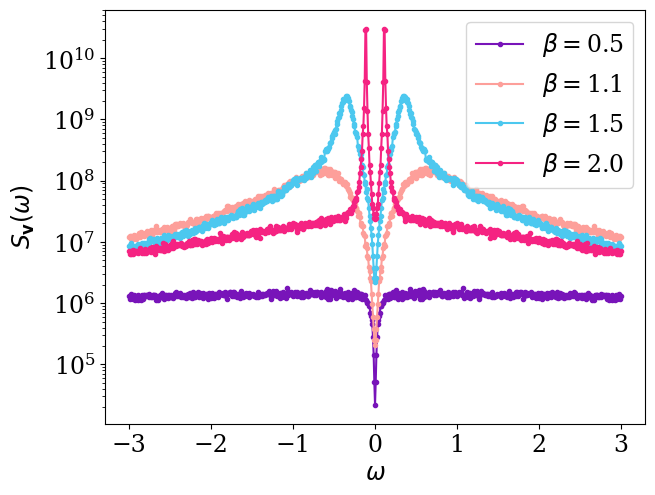

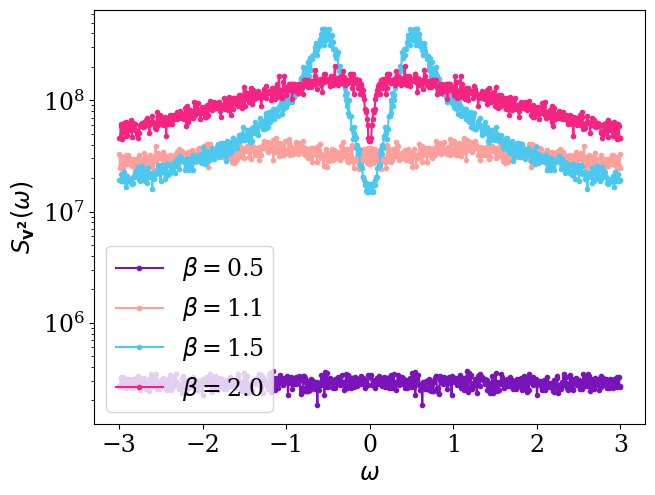

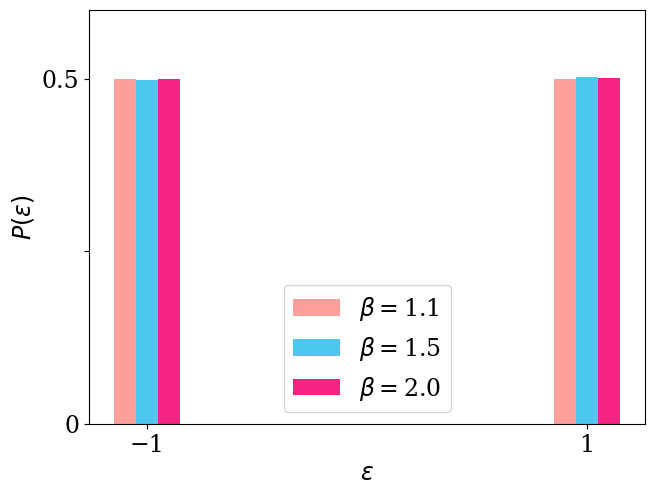

In [5]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams['text.usetex'] = False
params = {'text.usetex' : False,
          'font.size' : 17,
          'font.family' : 'serif',
          }
plt.rcParams.update(params)
color_show = [ '#7814B9', '#FD9F9A', '#4CC8EF', '#F52382' ] # list of colors for the different curves

beta_show = [ 0.5, 1.1, 1.5, 2. ]
# values of the windsock parameter to display
ks = 0.027 # spring constant for the confining potential
gam = 18. # friction coefficient of the propulsive force
eps = 0.025 # eta/gamma_p with eta the amplitude of the non-linear correction to the windsock amplification and gamma_p the friction coefficient of the propulsive force
sigma = 2. # amplitude of the noise

# PLOT THE VELOCTY SPECTRUM 

f, ax = plt.subplots()
ax.set_yscale('log')
k = 0
for be in beta_show:
    data = np.genfromtxt('./spectrum_k{0:.3f}_gammaP{1:.2f}_beta{2:.2f}_eps{3:.3f}_sigma{4:.2f}.txt'.format(ks, gam, be, eps, sigma))
    omega = data[:,0]
    spectrum = data[:,1]
    omega = omega[::2] # plot one every two points
    spectrum = spectrum[::2] # plot one every two points
    spectrum = spectrum[np.absolute(omega) < 3.] # limit the range of omega
    omega = omega[np.absolute(omega) < 3.] # limit the range of omega
    ax.plot(omega, spectrum, marker = '.', linestyle = '-', c = color_show[k], label = r'$\beta=${0:.1f}'.format(be))
    k += 1   
ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$S_\mathbf{v}(\omega)$')
maj_loc = ticker.LogLocator(numticks = 9)
min_loc = ticker.LogLocator(subs = 'all', numticks = 9)
ax.yaxis.set_major_locator(maj_loc)
ax.yaxis.set_minor_locator(min_loc)
ax.legend()
plt.tight_layout(pad = 0.1, w_pad = 0.0, h_pad = -0.1)
plt.show()

# PLOT THE SPECTRUM OF THE MAGNITUDE OF THE VELOCITY ###

f, ax = plt.subplots()
ax.set_yscale('log')
k = 0
for be in beta_show:
    data = np.genfromtxt('./spectrum_k{0:.3f}_gammaP{1:.2f}_beta{2:.2f}_eps{3:.3f}_sigma{4:.2f}.txt'.format(ks, gam, be, eps, sigma))
    omega = data[:,0]
    spectrum = data[:,2]
    omega = omega[::2] # plot one every two points
    spectrum = spectrum[::2] # plot one every two points
    spectrum[np.argmin(np.absolute(omega))] = np.nan # avoid overflow at zero angular frequency (the value of the spectrum is equal to the variance of v)
    spectrum = spectrum[np.absolute(omega) < 3.]
    omega = omega[np.absolute(omega) < 3.]
    ax.plot(omega, spectrum, marker = '.', linestyle = '-', c = color_show[k], label = r'$\beta=${0:.1f}'.format(be))
    k += 1   
ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$S_\mathbf{v^2}(\omega)$')
maj_loc = ticker.LogLocator(numticks = 9)
min_loc = ticker.LogLocator(subs = 'all', numticks = 9)
ax.yaxis.set_major_locator(maj_loc)
ax.yaxis.set_minor_locator(min_loc)
ax.legend()
plt.tight_layout(pad = 0.1, w_pad = 0.0, h_pad = -0.1)
plt.show()

# PLOT THE SPIN HISTOGRAM 

x = np.array([-1, 1])
bar_width = 0.1 # width of the histogram bars
f, ax = plt.subplots()
k = 0
for be in beta_show:
    if be >= 1.: # no oscillation below the bifurcation
        data = np.genfromtxt('./proba_spin_k{0:.3f}_gammaP{1:.2f}_beta{2:.2f}_eps{3:.3f}_sigma{4:.2f}.txt'.format(ks, gam, be, eps, sigma))
        proba = data[:,1]
        ax.bar(x + ( k - len(beta_show) * 0.5 ) * bar_width, proba, width = bar_width, color = color_show[k], label = r'$\beta=${0:.1f}'.format(be))
    k += 1
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel(r'$P(\epsilon)$')
ax.set_xticks([-1, 1])
ax.set_yticks([0, 0.25, 0.5])
ax.set_yticklabels(['0','','0.5'])
ax.set_ylim(0., 0.6)
ax.legend()
plt.tight_layout(pad = 0.1, w_pad = 0.0, h_pad = -0.1)
plt.show()
